# Visualizing Price Movement

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm

In [9]:
#path to the data folder, edit if necesssary
path = "./data/"

#filenames
file_power = "competitor_market_prices_power.csv"
file_gas = "competitor_market_prices_gas.csv"
master_power = "master_competitor_market_prices_power.csv"
master_gas = "master_competitor_market_prices_gas.csv"

#Price Filenames
power_prices = 'power_prices'
gas_prices = 'gas_prices'

In [5]:
#Reading in gas and power prices
df_power_prices = pd.read_csv(path + power_prices)
df_gas_prices = pd.read_csv(path + gas_prices)
df_power_prices

,Dates,spot_peak,spot_base,y_ahead_peak,2y_ahead_peak,3y_ahead_peak,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak
0,2021-05-24,26.460833,31.645417,74.60,72.05,70.45,64.20,61.08,59.28,26.46,31.65,64.02,75.35,70.28,90.30
1,2021-05-25,59.137500,59.780417,75.47,72.68,70.68,64.97,61.66,59.90,59.14,59.78,64.77,76.86,71.40,91.49
2,2021-05-26,66.536667,65.605833,77.00,73.15,71.00,66.21,62.18,60.22,66.54,65.61,66.91,79.14,73.63,93.96
3,2021-05-27,73.450833,71.767500,75.05,71.82,70.44,64.24,60.53,58.83,73.45,71.77,65.82,76.58,72.16,90.86
4,2021-05-28,73.577500,73.602083,74.30,71.08,69.50,63.96,60.08,58.13,73.58,73.60,64.96,75.89,70.65,90.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2022-10-10,186.518333,162.090000,581.64,353.67,254.50,427.00,270.00,195.00,186.52,162.09,344.89,389.71,470.80,492.09
505,2022-10-11,291.780833,259.873750,585.40,355.50,253.50,435.64,270.00,194.92,291.78,259.87,345.31,398.27,469.67,492.92
506,2022-10-12,299.796667,282.535833,590.00,355.46,253.61,434.00,268.00,193.88,299.80,282.54,341.97,389.53,454.50,485.41
507,2022-10-13,287.572500,257.455833,584.15,353.50,248.16,424.00,268.01,185.24,287.57,257.46,336.63,383.04,449.29,473.85


In [23]:
#Reading in gas and power prices
df_power_prices = pd.read_csv(path + power_prices, index_col = 'Dates')
df_gas_prices = pd.read_csv(path + gas_prices, index_col = 'date')

df_power_prices = df_power_prices.loc[df_power_prices.index > "2021-05-24"]
df_gas_prices = df_gas_prices.loc[df_gas_prices.index > "2021-05-24"]

df_power_prices

,spot_peak,spot_base,y_ahead_peak,2y_ahead_peak,3y_ahead_peak,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak
Dates,,,,,,,,,,,,,,
2021-05-25,59.137500,59.780417,75.47,72.68,70.68,64.97,61.66,59.90,59.14,59.78,64.77,76.86,71.40,91.49
2021-05-26,66.536667,65.605833,77.00,73.15,71.00,66.21,62.18,60.22,66.54,65.61,66.91,79.14,73.63,93.96
2021-05-27,73.450833,71.767500,75.05,71.82,70.44,64.24,60.53,58.83,73.45,71.77,65.82,76.58,72.16,90.86
2021-05-28,73.577500,73.602083,74.30,71.08,69.50,63.96,60.08,58.13,73.58,73.60,64.96,75.89,70.65,90.33
2021-05-29,45.800833,56.487917,74.05,70.75,69.47,63.52,59.84,57.85,45.80,56.49,53.35,68.40,70.43,90.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10,186.518333,162.090000,581.64,353.67,254.50,427.00,270.00,195.00,186.52,162.09,344.89,389.71,470.80,492.09
2022-10-11,291.780833,259.873750,585.40,355.50,253.50,435.64,270.00,194.92,291.78,259.87,345.31,398.27,469.67,492.92
2022-10-12,299.796667,282.535833,590.00,355.46,253.61,434.00,268.00,193.88,299.80,282.54,341.97,389.53,454.50,485.41


In [27]:
#Generating percentage returns / price changes dataset
df_power_pct = df_power_prices.pct_change().fillna(0)
df_gas_pct = df_gas_prices.pct_change().fillna(0)

In [28]:
df_gas_pct

,spot,y_ahead_gas,2y_ahead_gas,3y_ahead_gas,d_ahead_gas,m_ahead_gas,4m_ahead_gas
date,,,,,,,
2022-10-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-10-13,0.071421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-10-12,0.013632,0.046281,0.040041,0.027623,0.013632,0.041665,0.017875
2022-10-11,-0.013140,0.026258,0.016864,0.021548,-0.013140,-0.018793,0.013823
2022-10-10,0.131571,-0.014165,-0.032902,-0.014724,0.131571,-0.020651,-0.024184
...,...,...,...,...,...,...,...
2021-05-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-28,0.028314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-27,0.041340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
#Reading in master data
df_power = pd.read_csv(path + master_power)
df_power.set_index(pd.to_datetime(df_power['date_valid_from']), inplace = True)
df_gas = pd.read_csv(path + master_gas)
df_gas.set_index(pd.to_datetime(df_gas['date_valid_from']), inplace = True)

In [43]:
df_gas_prices.index = pd.to_datetime(df_gas_prices.index)
df_power_prices.index = pd.to_datetime(df_power_prices.index)

In [316]:
#Segmenting data according to strat_index
df_power_1 = df_power_test.loc[df_power_test.strat_index == 1]
df_power_2 = df_power_test.loc[df_power_test.strat_index == 2]
df_power_3 = df_power_test.loc[df_power_test.strat_index == 3]
df_power_4 = df_power_test.loc[df_power_test.strat_index == 4]
df_power_5 = df_power_test.loc[df_power_test.strat_index == 5]

In [29]:
#Regrouping columns to reflect validity periods of pricing only (aggregating rank as mean)
gb_cols = ['price_year_eur',
          'post_code',
           'city',
          'energy',
          'consumption_range_kwh',
          'supplier',
          'tariff']

agg_dict = {'rank':'mean',
           'date_valid_from':'min',
           'date_valid_to':'max'}


test = df_power.groupby(gb_cols).agg(agg_dict).reset_index()

# Ideas
1. Aggregate columns so a validity period corresponds to a price change
2. Convert prices into price pct_changes
3. Build a model predicting average price reaction (e.g. percent increase/decrease compared to prev validity period) given that a supplier is repricing the tariff on that date with supplier strat index, previous rank and price change in pct as input features which outputs household price change as output


In [91]:
#Building validity period feature
test.date_valid_to = pd.to_datetime(test.date_valid_to)
test.date_valid_from = pd.to_datetime(test.date_valid_from)
test['validity_period'] = (test['date_valid_to'] - test['date_valid_from']).dt.days
test

,price_year_eur,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,date_valid_from,date_valid_to,validity_period
0,86.86,40625,Düsseldorf,power,250,Pineapple,Skorupi,1.000000,2021-09-16,2021-09-17,1
1,88.37,70499,Stuttgart,power,250,Downburst,Barbaracle,1.000000,2021-10-02,2021-10-05,3
2,88.37,70499,Stuttgart,power,250,Downburst,Electabuzz,1.000000,2021-08-26,2021-09-30,35
3,89.04,70499,Stuttgart,power,250,Gregale,Cubone,1.666667,2021-08-26,2021-10-07,42
4,92.39,70499,Stuttgart,power,250,Downburst,Barbaracle,1.000000,2021-10-08,2021-10-08,0
...,...,...,...,...,...,...,...,...,...,...,...
11940357,725516.51,33332,Gütersloh,power,12000,Papagayos,Axew,17.500000,2021-12-17,2022-01-04,18
11940358,725516.62,33332,Gütersloh,power,12000,Monsunwind,Aerodactyl,32.000000,2021-12-16,2021-12-17,1
11940359,725543.05,33332,Gütersloh,power,12000,Monsunwind,Abra,33.000000,2021-12-16,2021-12-17,1
11940360,1209103.81,33332,Gütersloh,power,20000,Monsunwind,Aerodactyl,24.000000,2021-12-16,2021-12-17,1


<AxesSubplot:xlabel='date_valid_from'>

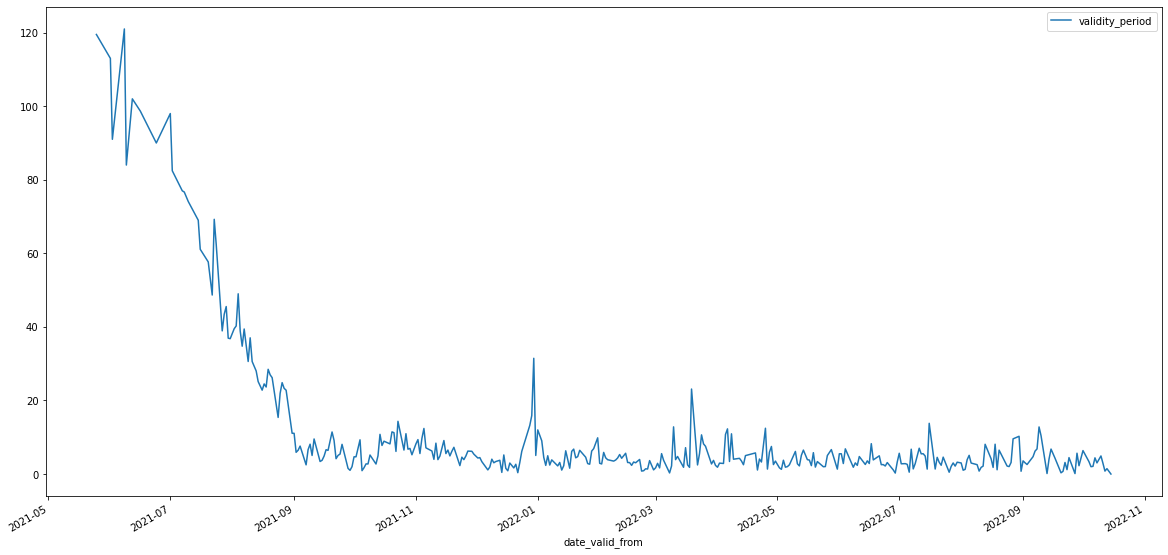

In [263]:
#Observing average validity periods over time across all suppliers

validity_df = test.groupby('date_valid_from').agg({'validity_period': 'mean'})
validity_df.plot(figsize = (20,10))

In [264]:
#Aggregating highly correlated price data
agg_daily = df_power_prices[['spot_peak', 'spot_base', 'd_ahead_peak', 'd_ahead_base']]
agg_monthly = df_power_prices[['m_ahead_base', '6m_ahead_base', 'm_ahead_peak', '6m_ahead_peak']]
agg_yearly = df_power_prices[['y_ahead_base', '2y_ahead_base', '3y_ahead_base', 'y_ahead_peak', '2y_ahead_peak', '3y_ahead_peak']]

df_power_prices_agg = pd.DataFrame({'current_price_index': agg_daily.mean(axis = 1),
                     'months_ahead_price_index': agg_monthly.mean(axis = 1),
                     'years_ahead_price_index': agg_yearly.mean(axis = 1)}).pct_change()

In [265]:
#Looking at correlations of price_pct_changes
df_power_prices_agg.corr()

,current_price_index,months_ahead_price_index,years_ahead_price_index
current_price_index,1.000000,-0.000061,0.016976
months_ahead_price_index,-0.000061,1.000000,0.721104
years_ahead_price_index,0.016976,0.721104,1.000000


In [266]:
#Standardizing prices
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler() 
#index = df_power_prices_agg.index
#df_power_prices_agg = pd.DataFrame(scaler.fit_transform(df_power_prices_agg), columns = df_power_prices_agg.columns).set_index(index)

In [267]:
#Joining mean validity dates per day and aggregated standardized power prices
validity_df = validity_df.join(df_power_prices_agg)
validity_df.dropna(inplace = True)

In [268]:
#Regressing avg validity periods on short and long term price index

X = validity_df[['current_price_index', 'years_ahead_price_index']]
X = sm.add_constant(X)
y = validity_df['validity_period']
mod = sm.OLS(y, X)
res = mod.fit()

#display regression coefficients and R-squared value of model
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        validity_period   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7906
Date:                Mon, 19 Dec 2022   Prob (F-statistic):              0.454
Time:                        00:12:28   Log-Likelihood:                -1547.3
No. Observations:                 354   AIC:                             3101.
Df Residuals:                     351   BIC:                             3112.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [283]:
#Looking at average validity periods on days after price jumps / price drops
from datetime import datetime, timedelta

#Looking at avg validity periods on days directly following highest short term price jumps
#validity_df.reset_index(inplace = True)

short_term_j = validity_df['current_price_index'].nlargest(10).index + 1
short_term_d = validity_df['current_price_index'].nsmallest(10).index + 1 
print('Avg validity period following short term price jumps: ', validity_df.loc[short_term_j]['validity_period'].mean())
print('Avg validity period following short term price drops: ',validity_df.loc[short_term_d]['validity_period'].mean())

Avg validity period following short term price jumps:  7.921223352195395
Avg validity period following short term price drops:  16.49785248891761


In [284]:
#Validity Period reactions to price drops in month ahead index

m_ahead_j = validity_df['months_ahead_price_index'].nlargest(10).index + 1
m_ahead_d = validity_df['months_ahead_price_index'].nsmallest(10).index + 1 
print('Avg validity period following m_ahead price jumps: ',validity_df.loc[m_ahead_j]['validity_period'].mean())
print('Avg validity period following m_ahead price drops: ',validity_df.loc[m_ahead_d]['validity_period'].mean())

Avg validity period following m_ahead price jumps:  4.2275209717107645
Avg validity period following m_ahead price drops:  5.614287842223275


In [285]:
#Validity Period reactions to price drops in years ahead index

y_ahead_j = validity_df['years_ahead_price_index'].nlargest(10).index + 1
y_ahead_d = validity_df['years_ahead_price_index'].nsmallest(10).index + 1 
print('Avg validity period following y_ahead price jumps: ',validity_df.loc[y_ahead_j]['validity_period'].mean())
print('Avg validity period following y_ahead price drops: ',validity_df.loc[y_ahead_d]['validity_period'].mean())

Avg validity period following y_ahead price jumps:  2.788684613203036
Avg validity period following y_ahead price drops:  4.238640960009809
